In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats
import sys
import warnings
warnings.filterwarnings("ignore")

# Add src folder to path to import our custom utils
sys.path.append('../src')
from utils import compare_metrics, plot_forecasts

print("Libraries loaded.")

Libraries loaded.


In [20]:
df = pd.read_csv('../data/processed/df_stationary.csv', index_col=0, parse_dates=True)

In [21]:
# ENDOGENOUS: All economic variables (Domestic + Global)
# The model will forecast ALL of these simultaneously.
endo_vars = [
    'DLOG_Y_IPI',    # Target
    'X_PPI_Growth',  # Inflation
    'D_X_UNEMP',     # Unemployment
    'DLOG_X_OIL',    # Global Oil (modeled as feedback)
    'LOG_X_CLI'      # Global Sentiment (modeled as feedback)
]

# EXOGENOUS: Only the Dummies (Deterministic Shocks)
# These are known fixed values (0 in the future).
exog_vars = ['D_COVID', 'D_2008']

# Train/Test Split
n_obs = len(df)
n_test = int(n_obs * 0.20)
test_start_index = n_obs - n_test

actual_levels = np.exp(df['LOG_Y_IPI'].iloc[test_start_index:])

print(f"Test Set Size: {n_test} months")
print(f"Split Date: {df.index[test_start_index]}")

Test Set Size: 54 months
Split Date: 2018-06-01 00:00:00


## VAR-X model

### Best lag Selection

Before running the loop, we check the optimal lag order ($p$) on the training data to avoid data leakage.

In [22]:
# Initialize history
history_endo = df[endo_vars].iloc[:test_start_index].copy()
history_exog = df[exog_vars].iloc[:test_start_index].copy()

# Find target column index
target_col_idx = endo_vars.index('DLOG_Y_IPI')

# Select lag order once
initial_model = VAR(history_endo, exog=history_exog)
lag_selection = initial_model.select_order(maxlags=12)
optimal_lag = lag_selection.aic
print("The optimal lag is:",optimal_lag)

The optimal lag is: 4


So we will run $VAR-X(4)$ but also $VAR-X(1)$ since easier models usually perform better

### Residual Diagnostic

In [23]:
lag_to_test = 12

#### VAR-X(1)

In [24]:
varx_1 = VAR(history_endo, exog = history_exog).fit(1)

print("DIAGNOSTIC CHECK VAR-X(1)")
print("="*50)

# IMPORTANT: Remove the first residual (initialization artifact)
residuals_var = varx_1.resid['DLOG_Y_IPI']

# -------------------------------------------------------
# CHECK 1: ZERO MEAN (T-Test)
# -------------------------------------------------------
t_stat, p_value_mean = stats.ttest_1samp(residuals_var, 0)

print(f"Mean of Residuals: {residuals_var.mean():.5f}")
print(f"T-Test P-value:    {p_value_mean:.5f}")

if p_value_mean < 0.05:
    print("❌ Bias Check: FAIL (Mean is significantly different from 0)")
else:
    print("✅ Bias Check: PASS (Mean is effectively 0)")

print("-" * 30)

# -------------------------------------------------------
# CHECK 2: NO AUTOCORRELATION (Ljung-Box Q Test)
# -------------------------------------------------------
lb_result = acorr_ljungbox(residuals_var, lags=[lag_to_test], return_df=True)
p_value_lb = lb_result['lb_pvalue'].iloc[0]

print(f"Ljung-Box (Lag {lag_to_test}) P-value: {p_value_lb:.5f}")

if p_value_lb < 0.05:
    print("❌ Correlation Check: FAIL (Residuals are correlated)")
else:
    print("✅ Correlation Check: PASS (Residuals look like White Noise)")

DIAGNOSTIC CHECK VAR-X(1)
Mean of Residuals: 0.00000
T-Test P-value:    1.00000
✅ Bias Check: PASS (Mean is effectively 0)
------------------------------
Ljung-Box (Lag 12) P-value: 0.14881
✅ Correlation Check: PASS (Residuals look like White Noise)


#### VAR-X(4)

In [25]:
varx_4 = VAR(history_endo, exog = history_exog).fit(optimal_lag)

print("DIAGNOSTIC CHECK VAR-X(4)")
print("="*50)

# IMPORTANT: Remove the first residual (initialization artifact)
residuals_var_4 = varx_4.resid['DLOG_Y_IPI']

# -------------------------------------------------------
# CHECK 1: ZERO MEAN (T-Test)
# -------------------------------------------------------
t_stat, p_value_mean = stats.ttest_1samp(residuals_var_4, 0)

print(f"Mean of Residuals: {residuals_var_4.mean():.5f}")
print(f"T-Test P-value:    {p_value_mean:.5f}")

if p_value_mean < 0.05:
    print("❌ Bias Check: FAIL (Mean is significantly different from 0)")
else:
    print("✅ Bias Check: PASS (Mean is effectively 0)")

print("-" * 30)

# -------------------------------------------------------
# CHECK 2: NO AUTOCORRELATION (Ljung-Box Q Test)
# -------------------------------------------------------
lb_result = acorr_ljungbox(residuals_var_4, lags=[lag_to_test], return_df=True)
p_value_lb = lb_result['lb_pvalue'].iloc[0]

print(f"Ljung-Box (Lag {lag_to_test}) P-value: {p_value_lb:.5f}")

if p_value_lb < 0.05:
    print("❌ Correlation Check: FAIL (Residuals are correlated)")
else:
    print("✅ Correlation Check: PASS (Residuals look like White Noise)")

DIAGNOSTIC CHECK VAR-X(4)
Mean of Residuals: 0.00000
T-Test P-value:    1.00000
✅ Bias Check: PASS (Mean is effectively 0)
------------------------------
Ljung-Box (Lag 12) P-value: 0.60611
✅ Correlation Check: PASS (Residuals look like White Noise)


Since both pass both tests we will select the VAR-X(1) being a way simpler model

### Expanding-Window Training

In [26]:
# CRITICAL: Clear lists before running the loop
preds_growth = []
preds_level = []

for t in range(len(actual_levels)):
    # Fit Model
    model = VAR(history_endo, exog=history_exog)
    model_fit = model.fit(optimal_lag)
    
    # Prepare Inputs
    last_obs = history_endo.values[-optimal_lag:]
    next_idx = test_start_index + t
    future_exog = df[exog_vars].iloc[next_idx].values.reshape(1, -1)
    
    # Forecast Growth
    fc = model_fit.forecast(y=last_obs, exog_future=future_exog, steps=1)
    pred_growth = fc[0, target_col_idx]
    
    # Reconstruct Level: exp( Last_Actual_Log_Level + Predicted_Growth )
    last_actual_log_level = df['LOG_Y_IPI'].iloc[next_idx - 1]
    pred_level = np.exp(last_actual_log_level + pred_growth)
    
    preds_level.append(pred_level)
    
    # Update History
    next_row_endo = df[endo_vars].iloc[next_idx]
    next_row_exog = df[exog_vars].iloc[next_idx]
    history_endo.loc[next_row_endo.name] = next_row_endo
    history_exog.loc[next_row_exog.name] = next_row_exog

print(f"Forecast Complete. Predictions generated: {len(preds_level)}")

Forecast Complete. Predictions generated: 54


In [27]:
preds_level_1 = []
pred_growth_1= []

history_endo_1 = df[endo_vars].iloc[:test_start_index].copy()
history_exog_1 = df[exog_vars].iloc[:test_start_index].copy()

for t in range(len(actual_levels)):
    # Fit Model
    model = VAR(history_endo_1, exog=history_exog_1)
    model_fit = model.fit(1)
    
    # Prepare Inputs
    last_obs = history_endo_1.values[-1:]
    next_idx = test_start_index + t
    future_exog = df[exog_vars].iloc[next_idx].values.reshape(1, -1)
    
    # Forecast Growth
    fc = model_fit.forecast(y=last_obs, exog_future=future_exog, steps=1)
    pred_growth_1= fc[0, target_col_idx]
    
    # Reconstruct Level: exp( Last_Actual_Log_Level + Predicted_Growth )
    last_actual_log_level = df['LOG_Y_IPI'].iloc[next_idx - 1]
    pred_level = np.exp(last_actual_log_level + pred_growth)
    
    preds_level_1.append(pred_level)
    
    # Update History
    next_row_endo = df[endo_vars].iloc[next_idx]
    next_row_exog = df[exog_vars].iloc[next_idx]
    history_endo_1.loc[next_row_endo.name] = next_row_endo
    history_exog_1.loc[next_row_exog.name] = next_row_exog

print(f"Forecast Complete. Predictions generated: {len(preds_level_1)}")

Forecast Complete. Predictions generated: 54


In [28]:
# Benchmark (Random Walk)

# Shift actual levels by 1 to simulate "Tomorrow = Today"
pred_rw_level = actual_levels.shift(1)
pred_rw_level.iloc[0] = np.exp(df['LOG_Y_IPI'].iloc[test_start_index - 1])

### Evaluation

In [29]:
# Create series with correct index
pred_var_4 = pd.Series(preds_level, index=actual_levels.index)
pred_var_1 = pd.Series(preds_level_1, index=actual_levels.index)

preds_dict = {
    'VAR-X(1)': pred_var_1,
    'VAR-X(4)': pred_var_4,
    'Random Walk': pred_rw_level
}

print("\n--- Final Evaluation (RMSE on Original Levels) ---")
metrics_df = compare_metrics(actual_levels, preds_dict, benchmark_name= "Random Walk")
print(metrics_df)


--- Final Evaluation (RMSE on Original Levels) ---
                  RMSE       MAE  RMSFE Ratio  MAFE Ratio
Random Walk   6.235937  3.039524     1.000000    1.000000
VAR-X(1)      6.304961  3.160717     1.011069    1.039872
VAR-X(4)     10.427251  4.502877     1.672123    1.481441


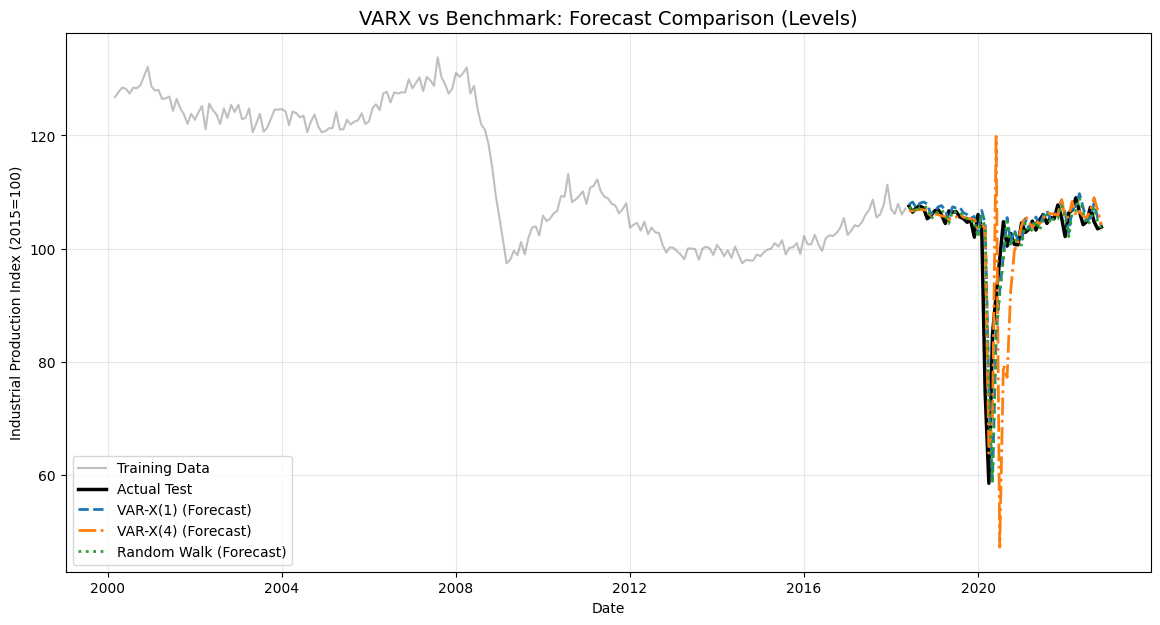

In [30]:
plot_forecasts(
    test=actual_levels,
    predictions_dict=preds_dict,
    train=np.exp(df['LOG_Y_IPI'].iloc[:test_start_index]),
    title="VARX vs Benchmark: Forecast Comparison (Levels)",
    ylabel="Industrial Production Index (2015=100)"
)

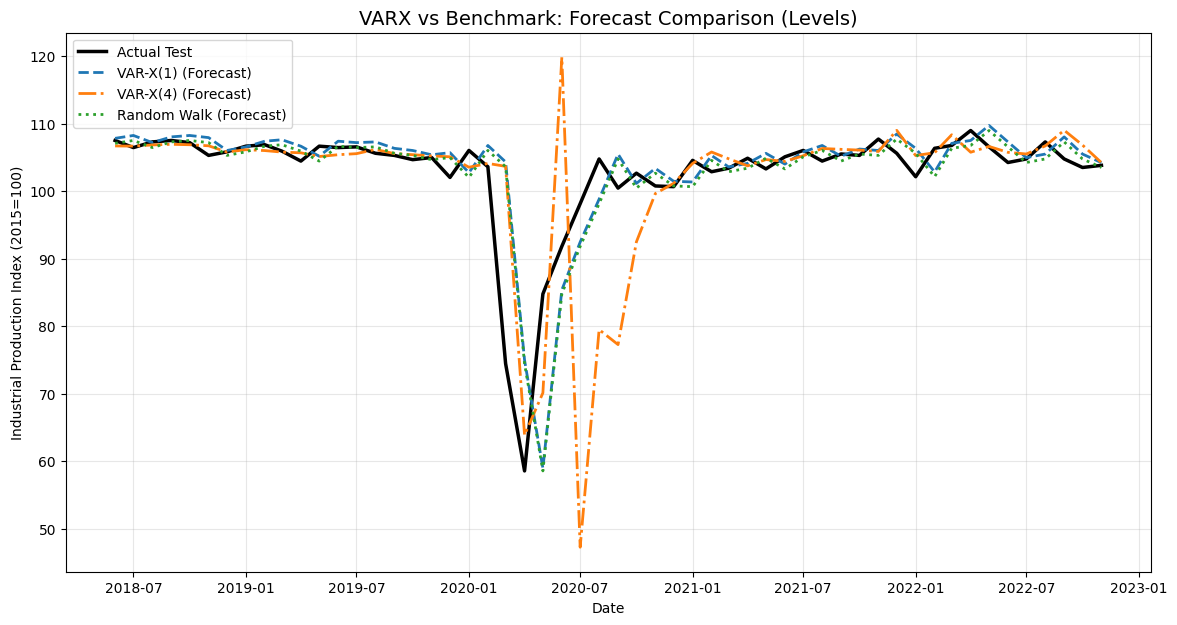

In [31]:
plot_forecasts(
    test=actual_levels,
    predictions_dict=preds_dict,
    train=None,
    title="VARX vs Benchmark: Forecast Comparison (Levels)",
    ylabel="Industrial Production Index (2015=100)"
)

1. VAR-X(1) Model $$y_t = c + \Phi_1 * y_{t-1} + B * x_t + epsilon_t$$

2. VAR-X(4) Model $$y_t = c + \Phi_1 * y_{t-1} + \Phi_2 * y_{t-2} + \Phi_3 * y_{t-3} + \Phi_4 * y_{t-4} + B * x_t + epsilon_t$$

Variables:

- $y_t = [IPI_{Growth_t}, PPI_{Growth_t}, Unemp_t, Oil_{Price_t}, Sentiment_t]^T$
- $x_t = [D_{COVID_t}, D_{2008_t}]^T$
- $y_{t-k}$ represents the vector of economic variables lagged by k months.
- $\Phi_k$ represents the coefficient matrix for the k-th lag.
- $B$ is the coefficient matrix for the exogenous dummies.
- $c$ is the constant vector.
- $epsilon_t$ is the white noise error vector.